### increase ram size if required

In [ ]:
i = []
while True:
  i.append(i)

### mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import spectral.io.envi as envi
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import cross_val_score


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense

print(tf.__version__)

2.4.1


### load dataset

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Thesis/mean_dataset/normalized/dataset_mean_normalized.csv', encoding='latin-1')

In [ ]:
dataset.head(3)

,img_name,PCR,Band_001,Band_002,Band_003,Band_004,Band_005,Band_006,Band_007,Band_008,Band_009,Band_010,Band_011,Band_012,Band_013,Band_014,Band_015,Band_016,Band_017,Band_018,Band_019,Band_020,Band_021,Band_022,Band_023,Band_024,Band_025,Band_026,Band_027,Band_028,Band_029,Band_030,Band_031,Band_032,Band_033,Band_034,Band_035,Band_036,Band_037,Band_038,...,Band_147,Band_148,Band_149,Band_150,Band_151,Band_152,Band_153,Band_154,Band_155,Band_156,Band_157,Band_158,Band_159,Band_160,Band_161,Band_162,Band_163,Band_164,Band_165,Band_166,Band_167,Band_168,Band_169,Band_170,Band_171,Band_172,Band_173,Band_174,Band_175,Band_176,Band_177,Band_178,Band_179,Band_180,Band_181,Band_182,Band_183,Band_184,Band_185,Band_186
0,Ind-AT1_V1-A_Blatt_VNIR_leaf1,1,0.042757,0.042500,0.041592,0.041078,0.040800,0.040361,0.039828,0.038660,0.038783,0.038519,0.038543,0.038561,0.038081,0.038824,0.039211,0.040024,0.040291,0.040896,0.041143,0.041149,0.041354,0.040995,0.041068,0.041388,0.041236,0.041743,0.042129,0.043451,0.045655,0.047804,0.051727,0.056356,0.061765,0.069235,0.076570,0.084432,0.092334,0.099457,...,0.374524,0.372751,0.367952,0.372332,0.368956,0.368538,0.371721,0.366032,0.369821,0.365835,0.365953,0.361308,0.369411,0.366450,0.361704,0.359386,0.360887,0.360975,0.362344,0.356860,0.358135,0.358035,0.358289,0.354475,0.354115,0.355115,0.353141,0.352625,0.355285,0.353739,0.352703,0.346970,0.349752,0.353019,0.347417,0.359075,0.343918,0.353503,0.354541,0.351962
1,Ind-AT1_V1-A_Blatt_VNIR_leaf2,1,0.054513,0.053463,0.052781,0.052297,0.052243,0.051998,0.051635,0.050230,0.050737,0.050458,0.050446,0.050422,0.049771,0.050815,0.051363,0.052438,0.052924,0.053760,0.054197,0.054258,0.054424,0.053992,0.054002,0.054436,0.054224,0.054891,0.055532,0.057463,0.060564,0.063724,0.069373,0.076115,0.084015,0.094852,0.105776,0.117760,0.130039,0.141149,...,0.464383,0.462340,0.456413,0.461740,0.457462,0.456875,0.460833,0.453393,0.458087,0.453037,0.453090,0.447301,0.457268,0.453473,0.447552,0.444284,0.445377,0.444452,0.445233,0.438580,0.441019,0.441110,0.441341,0.437160,0.436360,0.437367,0.434748,0.433953,0.436947,0.435019,0.433693,0.426707,0.430217,0.434486,0.427096,0.441592,0.422943,0.434340,0.435683,0.432486
2,Ind-AT1_V1-A_Blatt_VNIR_leaf3,1,0.045973,0.044950,0.043583,0.043210,0.043156,0.042604,0.042271,0.041378,0.041775,0.041273,0.041186,0.041018,0.040566,0.041445,0.041889,0.042783,0.043127,0.043670,0.043902,0.043824,0.043889,0.043486,0.043477,0.043759,0.043583,0.044062,0.044495,0.045952,0.048338,0.050775,0.055047,0.060031,0.065683,0.073364,0.080773,0.088667,0.096480,0.103367,...,0.437286,0.435530,0.429971,0.434998,0.430716,0.430171,0.433931,0.427000,0.431423,0.426543,0.426435,0.421053,0.430575,0.427107,0.421556,0.418549,0.420126,0.419704,0.420925,0.414672,0.416421,0.416151,0.415843,0.411914,0.411053,0.412158,0.409740,0.408987,0.411997,0.410212,0.408952,0.402570,0.406094,0.410080,0.403254,0.416451,0.399093,0.409626,0.410648,0.407662


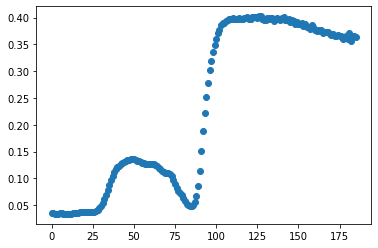

In [ ]:
plt.scatter(np.arange(186), dataset.iloc[4:5,2:].values)

In [ ]:
# shuffel dataset
dataset = dataset.sample(frac = 1)
dataset.head(3)

,img_name,PCR,Band_001,Band_002,Band_003,Band_004,Band_005,Band_006,Band_007,Band_008,Band_009,Band_010,Band_011,Band_012,Band_013,Band_014,Band_015,Band_016,Band_017,Band_018,Band_019,Band_020,Band_021,Band_022,Band_023,Band_024,Band_025,Band_026,Band_027,Band_028,Band_029,Band_030,Band_031,Band_032,Band_033,Band_034,Band_035,Band_036,Band_037,Band_038,...,Band_147,Band_148,Band_149,Band_150,Band_151,Band_152,Band_153,Band_154,Band_155,Band_156,Band_157,Band_158,Band_159,Band_160,Band_161,Band_162,Band_163,Band_164,Band_165,Band_166,Band_167,Band_168,Band_169,Band_170,Band_171,Band_172,Band_173,Band_174,Band_175,Band_176,Band_177,Band_178,Band_179,Band_180,Band_181,Band_182,Band_183,Band_184,Band_185,Band_186
111,Ind-K1-6_Blatt_VNIR_leaf6,0,0.062844,0.061342,0.060671,0.061331,0.061458,0.061608,0.061312,0.061390,0.060872,0.060592,0.060283,0.060003,0.060132,0.060347,0.061261,0.062015,0.062483,0.062424,0.062554,0.062916,0.062659,0.062837,0.063442,0.063254,0.063591,0.063832,0.064539,0.065072,0.066850,0.069329,0.073166,0.077665,0.084261,0.093398,0.103935,0.115929,0.130631,0.144828,...,0.473125,0.464971,0.470372,0.468819,0.465356,0.464644,0.463782,0.464182,0.464037,0.463044,0.456934,0.464596,0.456860,0.465603,0.456237,0.456461,0.450239,0.451513,0.448295,0.451848,0.456318,0.449201,0.444348,0.452550,0.454561,0.447834,0.449485,0.448263,0.440539,0.443799,0.441165,0.441017,0.446522,0.446276,0.440461,0.435480,0.433824,0.442211,0.438866,0.435861
41,Ind-AT1_V1-E_Blatt_VNIR_leaf4,0,0.065011,0.064625,0.064731,0.063544,0.064214,0.064837,0.060134,0.063846,0.063658,0.064037,0.063875,0.063604,0.063404,0.063750,0.063662,0.064209,0.064053,0.063868,0.064324,0.063774,0.063444,0.063697,0.064235,0.063404,0.062763,0.063413,0.063793,0.063868,0.064116,0.064302,0.064722,0.067314,0.068849,0.071154,0.075598,0.079971,0.085134,0.093290,...,0.464337,0.458206,0.462875,0.462360,0.462746,0.462625,0.461330,0.455735,0.459480,0.457138,0.459337,0.455119,0.451163,0.459632,0.457002,0.448401,0.452438,0.445304,0.437616,0.446628,0.447089,0.445251,0.446131,0.448615,0.446807,0.445699,0.446022,0.442390,0.435920,0.437242,0.429208,0.439585,0.428882,0.432865,0.430311,0.442713,0.439378,0.436734,0.433757,0.433323
10,Ind-AT1_V1-B_Blatt_VNIR_leaf10,1,0.033860,0.033897,0.033246,0.032633,0.033760,0.032938,0.032622,0.033263,0.033330,0.033228,0.032296,0.032959,0.032493,0.032875,0.033250,0.033240,0.033794,0.033363,0.033729,0.033754,0.033796,0.033620,0.033709,0.033731,0.033659,0.034278,0.034297,0.034858,0.035642,0.036611,0.038080,0.039854,0.042271,0.045467,0.048212,0.051576,0.054829,0.057724,...,0.354768,0.357501,0.354653,0.354215,0.357120,0.352162,0.348837,0.350742,0.353728,0.353947,0.351736,0.354389,0.350365,0.349522,0.348937,0.349197,0.350407,0.341813,0.349363,0.350054,0.346829,0.348502,0.341438,0.343755,0.338170,0.338754,0.342331,0.341238,0.339668,0.338983,0.338047,0.338307,0.332147,0.341694,0.340189,0.343669,0.338232,0.340444,0.332906,0.341993


In [ ]:
X = dataset.iloc[:,2:].values
y = np.array(dataset.PCR.values, dtype=int)

### preview bands 45 and 120

In [ ]:
band45 = X[:,45:46]

In [ ]:
band120 = X[:, 120:121]

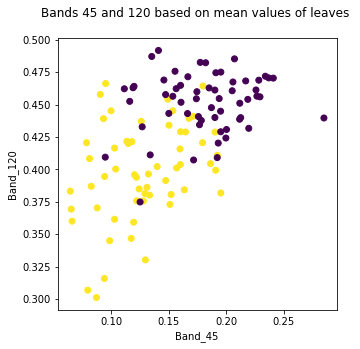

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(band45, band120, c=y)
plt.title('Bands 45 and 120 based on mean values of leaves \n')
plt.xlabel('Band_45')
plt.ylabel('Band_120')
plt.show()

### Logistic Regression (keras)

start preparing dataset

In [ ]:
input_shape = [X.shape[1],]
input_shape

[186]

In [ ]:
band_normalizer = preprocessing.Normalization(input_shape=input_shape)

In [ ]:
bands = np.array(X)

In [ ]:
band_normalizer.adapt(bands)

In [ ]:
model = tf.keras.Sequential([
    band_normalizer,
    layers.Dense(units=1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 186)               373       
_________________________________________________________________
dense (Dense)                (None, 1)                 187       
Total params: 560
Trainable params: 187
Non-trainable params: 373
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-3, patience=3)

In [ ]:
%%time
history = model.fit(
    X, y,
    epochs=100,
    # suppress logging
    verbose=1,
    # Calculate validation results on 20% of the training data
    # validation_data=(X_val, y_val), 
    validation_split = 0.2,
    callbacks=[callback]
    )

Epoch 1/100
3/3 [==============================] - 0s 69ms/step - loss: 0.5800 - accuracy: 0.7174 - val_loss: 0.5509 - val_accuracy: 0.7826
Epoch 2/100
3/3 [==============================] - 0s 35ms/step - loss: 0.5542 - accuracy: 0.7283 - val_loss: 0.6529 - val_accuracy: 0.5652
Epoch 3/100
3/3 [==============================] - 0s 36ms/step - loss: 0.5397 - accuracy: 0.7283 - val_loss: 0.5344 - val_accuracy: 0.8261
Epoch 4/100
3/3 [==============================] - 0s 38ms/step - loss: 0.5446 - accuracy: 0.7609 - val_loss: 0.5202 - val_accuracy: 0.8696
Epoch 5/100
3/3 [==============================] - 0s 38ms/step - loss: 0.5271 - accuracy: 0.7609 - val_loss: 0.6155 - val_accuracy: 0.6087
Epoch 6/100
3/3 [==============================] - 0s 36ms/step - loss: 0.5503 - accuracy: 0.7717 - val_loss: 0.5162 - val_accuracy: 0.8261
Epoch 7/100
3/3 [==============================] - 0s 39ms/step - loss: 0.5046 - accuracy: 0.8478 - val_loss: 0.5564 - val_accuracy: 0.7391
Epoch 8/100
3/3 [===

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
13,0.471367,0.826087,0.551299,0.695652,13
14,0.457783,0.847826,0.454052,0.913043,14
15,0.461294,0.880435,0.514537,0.739130,15
16,0.491999,0.771739,0.487075,0.739130,16
17,0.483846,0.793478,0.439649,0.913043,17


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 5])
  plt.xlabel('Epoch')
  plt.ylabel('error')
  plt.legend()
  plt.grid(True)

In [ ]:
def plot_accuracy(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.grid(True)

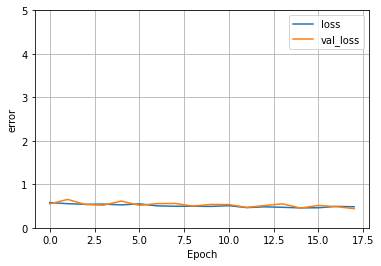

In [ ]:
plot_loss(history)

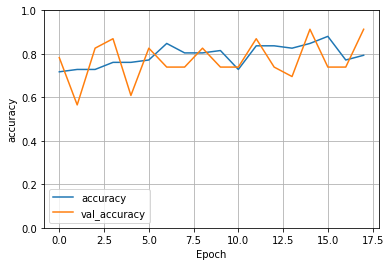

In [ ]:
plot_accuracy(history)

In [ ]:
# predict = model.predict(X)
# accuracy_score(np.round(predict), y[:])

### split dataset to train validation parts

In [ ]:
# # split dataset to train and validation parts
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
num_folds = 4
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)

In [ ]:
kf.get_n_splits(X)

4

In [ ]:
print(kf)

KFold(n_splits=4, random_state=42, shuffle=True)


In [ ]:
%%time
score = np.array([])
for train_index, val_index in kf.split(X):
  # print("TRAIN:", train_index, "TEST:", val_index)
  X_train, X_val = X[train_index], X[val_index]
  y_train, y_val = y[train_index], y[val_index]


  input_shape = [X.shape[1],]
  band_normalizer = preprocessing.Normalization(input_shape=input_shape)

  model = tf.keras.Sequential([
    band_normalizer,
    layers.Dense(units=1, activation='sigmoid')
  ])

  model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='binary_crossentropy', metrics=['accuracy'])

  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-3, patience=3)

  # %%time
  history = model.fit(
    X_train, y_train,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 25% of the training data
    # validation_split = 0.25,
    validation_data=(X_val, y_val), 
    callbacks=[callback]
    )
  
  predict = model.predict(X_val)
  acc = accuracy_score(np.round(predict), y_val)
  score = np.append(score, acc)

  # loss = history.history['loss']
  # val_loss = history.history['val_loss']
  # accuracy = history.history['accuracy']
  # val_accuracy = history.history['val_accuracy']

  hist = pd.DataFrame(history.history)

  accuracy = hist.accuracy.iloc[-1]

  # # Generate generalization metrics
  # scores = model.evaluate(X[test], y[test], verbose=0)
  # print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  # acc_per_fold.append(scores[1] * 100)
  # loss_per_fold.append(scores[0])



  # # Increase fold number
  # fold_no = fold_no + 1
  print(acc)
  # print(hist.accuracy)

print(score)
print(np.average(score))
  

0.6896551724137931
0.8620689655172413
0.6206896551724138
0.7142857142857143
[0.68965517 0.86206897 0.62068966 0.71428571]
0.7216748768472907
CPU times: user 11.9 s, sys: 292 ms, total: 12.2 s
Wall time: 11.7 s


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
score = np.array([])
for train_index, val_index in kf.split(X):
  # print("TRAIN:", train_index, "TEST:", val_index)
  X_train, X_val = X[train_index], X[val_index]
  y_train, y_val = y[train_index], y[val_index]

  clf = LogisticRegression(penalty='none' ,random_state=0).fit(X_train, y_train)
  predict = clf.predict(X_val)
  acc = accuracy_score(predict, y_val)
  score = np.append(score, acc)
  print(acc)

1.0
0.9310344827586207
0.9310344827586207
0.8571428571428571


In [ ]:
np.average(score)

0.9298029556650246

### Logistic Regression (sklearn)

In [ ]:
clf = LogisticRegression(penalty='none' ,random_state=42).fit(X_train, y_train)

In [ ]:
predict = clf.predict(X_val)

In [ ]:
accuracy_score(predict, y_val)

0.782608695652174

In [ ]:
print(classification_report(predict, y_val))

              precision    recall  f1-score   support

           0       0.64      0.88      0.74         8
           1       0.92      0.73      0.81        15

    accuracy                           0.78        23
   macro avg       0.78      0.80      0.78        23
weighted avg       0.82      0.78      0.79        23



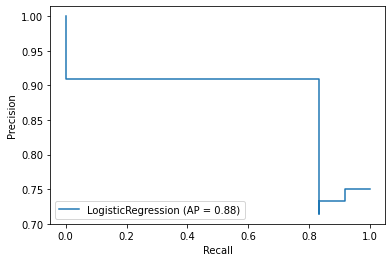

In [ ]:
disp = plot_precision_recall_curve(clf, X_val, y_val)

In [ ]:
scores = cross_val_score(clf, X, y, cv=5)
scores

array([1.        , 1.        , 0.86956522, 0.91304348, 0.91304348])

In [ ]:
np.average(scores)

0.9391304347826086

### Random Forest (sklearn)

In [ ]:
clf = RandomForestClassifier(max_depth=2, random_state=0)

In [ ]:
clf = clf.fit(X_train, y_train)

In [ ]:
predict = clf.predict(X_val)

In [ ]:
print(classification_report(y_val, predict, target_names=['Pos', 'Neg']))

              precision    recall  f1-score   support

         Pos       0.83      1.00      0.91        15
         Neg       1.00      0.79      0.88        14

    accuracy                           0.90        29
   macro avg       0.92      0.89      0.89        29
weighted avg       0.91      0.90      0.90        29



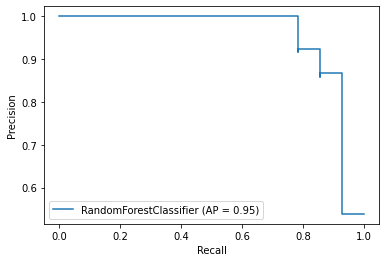

In [ ]:
disp = plot_precision_recall_curve(clf, X_val, y_val)

In [ ]:
scores = cross_val_score(clf, X, y, cv=5)
scores

array([0.86956522, 0.86956522, 0.65217391, 0.91304348, 0.86956522])

In [ ]:
np.average(scores)

0.8347826086956521

### LDA (sklearn)

In [ ]:
lda = LinearDiscriminantAnalysis()

In [ ]:
clf = lda.fit(X_train, y_train)

In [ ]:
predict = clf.predict(X_val)

In [ ]:
clf.explained_variance_ratio_

array([1.])

In [ ]:
accuracy_score(y_val, predict)

1.0

In [ ]:
print(classification_report(y_val, predict, target_names=['Pos', 'Neg']))

              precision    recall  f1-score   support

         Pos       1.00      1.00      1.00        15
         Neg       1.00      1.00      1.00        14

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



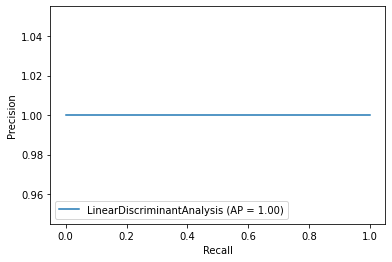

In [ ]:
disp = plot_precision_recall_curve(clf, X_val, y_val)

In [ ]:
scores = cross_val_score(clf, X, y, cv=5)
scores

array([1., 1., 1., 1., 1.])

In [ ]:
np.average(scores)

1.0

In [ ]:
colors = ['royalblue','red','deeppink', 'maroon', 'mediumorchid', 'tan', 'forestgreen', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

In [ ]:
clf = clf.transform(X_train)

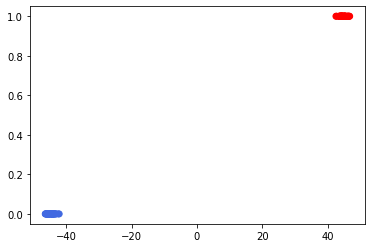

In [ ]:
plt.scatter(clf[:,0], y_train, c=vectorizer(y_train))

### SVM (sklearn)

In [ ]:
clf = SVC(shrinking=False)

In [ ]:
clf = clf.fit(X_train, y_train)

In [ ]:
predict = clf.predict(X_val)

In [ ]:
accuracy_score(y_val, predict)

0.8275862068965517

In [ ]:
print(classification_report(y_val, predict, target_names=['Pos', 'Neg']))

              precision    recall  f1-score   support

         Pos       0.75      1.00      0.86        15
         Neg       1.00      0.64      0.78        14

    accuracy                           0.83        29
   macro avg       0.88      0.82      0.82        29
weighted avg       0.87      0.83      0.82        29



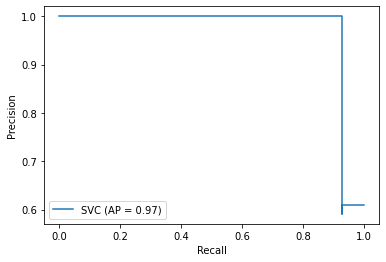

In [ ]:
disp = plot_precision_recall_curve(clf, X_val, y_val)

In [ ]:
scores = cross_val_score(clf, X, y, cv=5)
scores

array([0.86956522, 0.86956522, 0.69565217, 0.91304348, 0.73913043])

In [ ]:
np.average(scores)

0.8173913043478261

### restart runtime and clear ram

In [ ]:
# restart runtime and clear ram
import os, signal
os.kill(os.getpid(), signal.SIGKILL)